<a href="https://colab.research.google.com/github/akhileshmanukonda/Air-quality-project-/blob/main/original_air_quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DATA SCIENCE PROJECT**
AIR QUALITY FORECASTING

In [ ]:
!pip install pmdarima

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime as dt
from pandas import DatetimeIndex
from sklearn.impute import SimpleImputer
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor # for building random forest models
from sklearn.preprocessing import StandardScaler # for data preprocessing
import matplotlib.pyplot as plt # for data visualization
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV # Import GridSearchCV here
from sklearn.preprocessing import StandardScaler

IMPORTING DATA SET

In [ ]:
# Load the dataset
Air_quality = pd.read_csv('AP001.csv')
# Check for NaN values
print("Missing values before cleaning:\n", Air_quality.isnull().sum())
print(Air_quality)


Missing values before cleaning:
 From Date              0
To Date                0
PM2.5 (ug/m3)       4827
PM10 (ug/m3)        4700
NO (ug/m3)          3997
NO2 (ug/m3)         4050
NOx (ppb)           3835
NH3 (ug/m3)         5586
SO2 (ug/m3)         4865
CO (mg/m3)          4477
Ozone (ug/m3)       4583
Benzene (ug/m3)     3937
Toluene (ug/m3)     3937
Temp (degree C)     4037
RH (%)              3869
WS (m/s)            3851
WD (deg)            4494
SR (W/mt2)          4561
BP (mmHg)          57949
VWS (m/s)           3809
Xylene (ug/m3)      3950
RF (mm)             3865
AT (degree C)       4063
dtype: int64
                 From Date              To Date  PM2.5 (ug/m3)  PM10 (ug/m3)  \
0      2016-07-01 10:00:00  2016-07-01 11:00:00          10.67         39.00   
1      2016-07-01 11:00:00  2016-07-01 12:00:00           2.00         39.00   
2      2016-07-01 12:00:00  2016-07-01 13:00:00            NaN           NaN   
3      2016-07-01 13:00:00  2016-07-01 14:00:00            

# **PREPROCESSING AND NORMALISATION**

In [ ]:
# Identify numerical columns, excluding date-related ones
date_columns = ['From Date','To Date']  # Columns containing date information
numerical_cols = [col for col in Air_quality.select_dtypes(include=['number']).columns if col not in date_columns]

# Applying mean imputation only to non-date numerical columns
mean_imputer = SimpleImputer(strategy='mean')
Air_quality[numerical_cols] = mean_imputer.fit_transform(Air_quality[numerical_cols])

print("\nDataFrame after Mean Imputation (excluding date columns):")
print(Air_quality)



DataFrame after Mean Imputation (excluding date columns):
                 From Date              To Date  PM2.5 (ug/m3)  PM10 (ug/m3)  \
0      2016-07-01 10:00:00  2016-07-01 11:00:00      10.670000     39.000000   
1      2016-07-01 11:00:00  2016-07-01 12:00:00       2.000000     39.000000   
2      2016-07-01 12:00:00  2016-07-01 13:00:00      29.718423     58.531252   
3      2016-07-01 13:00:00  2016-07-01 14:00:00      29.718423     58.531252   
4      2016-07-01 14:00:00  2016-07-01 15:00:00      20.500000     50.000000   
...                    ...                  ...            ...           ...   
59145  2023-03-31 19:00:00  2023-03-31 20:00:00      53.000000     70.250000   
59146  2023-03-31 20:00:00  2023-03-31 21:00:00      58.500000     88.500000   
59147  2023-03-31 21:00:00  2023-03-31 22:00:00      44.250000     80.500000   
59148  2023-03-31 22:00:00  2023-03-31 23:00:00      31.250000     59.000000   
59149  2023-03-31 23:00:00  2023-04-01 00:00:00      26.00000

In [ ]:
# Extract the day from 'From' column
Air_quality['From Date'] = pd.to_datetime(Air_quality['From Date'])
Air_quality['Day'] = Air_quality['From Date'].dt.date

# Group by 'Day' and calculate the mean of numeric columns only
# Select only numeric columns before applying the aggregation
numeric_columns = Air_quality.select_dtypes(include=np.number).columns
daily_report = Air_quality.groupby('Day')[numeric_columns].agg('mean').reset_index()

# Display the daily report
print(daily_report)



             Day  PM2.5 (ug/m3)  PM10 (ug/m3)  NO (ug/m3)  NO2 (ug/m3)  \
0     2016-07-01      14.734060     51.897322   14.248995    38.607201   
1     2016-07-02      25.068159     64.285886   21.685903    43.966195   
2     2016-07-03      14.162500     46.146250   12.116250    41.458750   
3     2016-07-04      10.816338     31.315677    8.549576    39.182377   
4     2016-07-05       4.718750     17.228750   15.559167    39.981667   
...          ...            ...           ...         ...          ...   
2460  2023-03-27      37.593750     61.177083   11.168333    38.981667   
2461  2023-03-28      40.843750     59.895833    7.777917    38.923333   
2462  2023-03-29      39.696601     61.511719    4.961250    32.171250   
2463  2023-03-30      49.364583     72.395833    5.115833    31.208333   
2464  2023-03-31      39.739583     60.291667    6.989167    35.660000   

      NOx (ppb)  NH3 (ug/m3)  SO2 (ug/m3)  CO (mg/m3)  Ozone (ug/m3)  ...  \
0     29.788065     8.074699     6

EXPLORATORY DATA ANALYSIS

In [ ]:
print("Descriptive analysis:")
daily_report.describe().transpose()

Descriptive analysis:


,count,mean,std,min,25%,50%,75%,max
PM2.5 (ug/m3),2465.0,29.715890,17.888784,4.179518,15.250000,25.611952,40.083333,129.062500
PM10 (ug/m3),2465.0,58.530130,25.904257,11.679688,38.187500,56.114583,76.104167,223.166511
NO (ug/m3),2465.0,13.078161,8.779540,0.952917,6.388333,11.543333,17.556667,56.955417
NO2 (ug/m3),2465.0,39.195310,26.598895,3.803333,20.703333,33.044583,50.167500,300.621667
NOx (ppb),2465.0,31.171219,19.084635,0.000000,18.259583,27.411250,39.445310,186.872083
NH3 (ug/m3),2465.0,10.057557,5.159204,1.498750,6.555000,8.914583,11.606250,46.636667
SO2 (ug/m3),2465.0,5.782310,2.385015,1.007177,4.390833,5.332500,6.672874,22.193333
CO (mg/m3),2465.0,0.634853,0.262022,0.000000,0.425417,0.649167,0.835000,2.366250
Ozone (ug/m3),2465.0,28.679321,15.029779,1.634167,17.613333,24.897917,35.198164,101.444583
Benzene (ug/m3),2465.0,0.813854,0.598598,0.000000,0.420713,0.695417,1.080000,8.075417


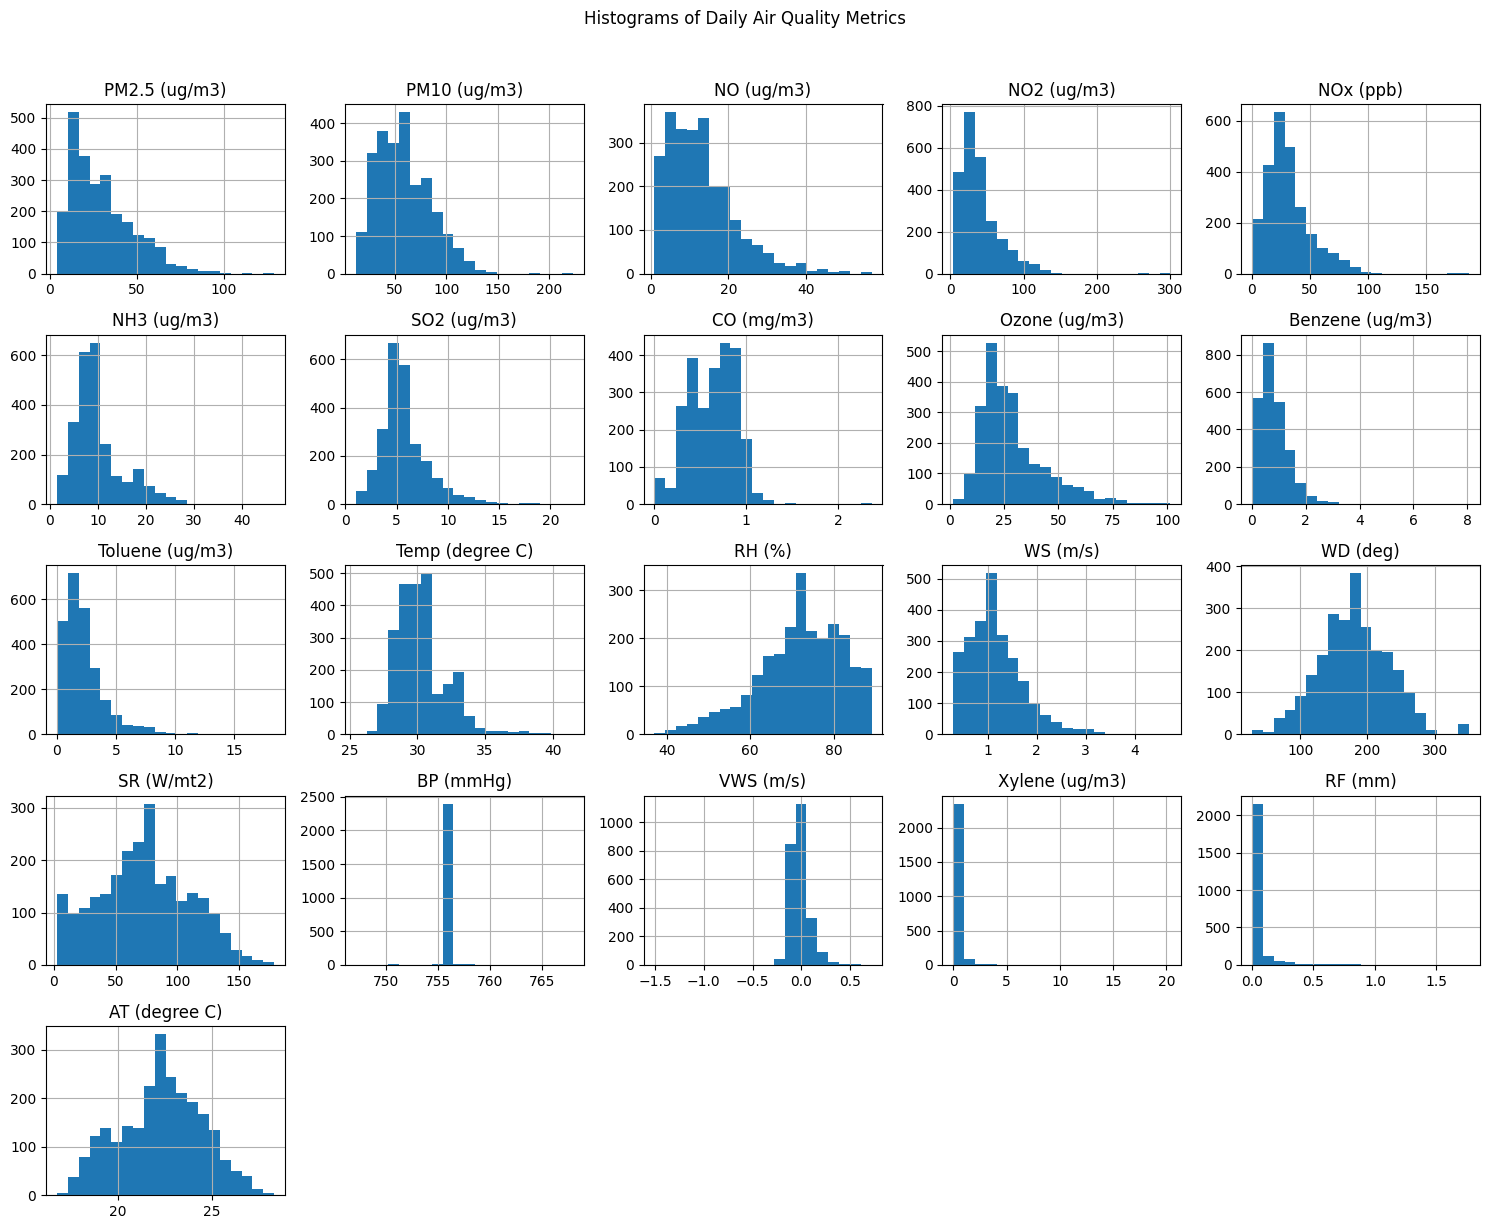

In [ ]:
# Plot histograms for all numeric columns
daily_report.hist(bins=20, figsize=(15, 12))
plt.suptitle("Histograms of Daily Air Quality Metrics", y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
daily_report

,Day,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),...,Temp (degree C),RH (%),WS (m/s),WD (deg),SR (W/mt2),BP (mmHg),VWS (m/s),Xylene (ug/m3),RF (mm),AT (degree C)
0,2016-07-01,14.734060,51.897322,14.248995,38.607201,29.788065,8.074699,6.189052,0.447126,16.097350,...,33.348795,66.863919,1.967921,216.565027,73.196523,755.713988,-0.087953,0.140201,0.007503,23.672024
1,2016-07-02,25.068159,64.285886,21.685903,43.966195,38.420962,8.564538,5.242600,0.930998,18.867210,...,31.985795,67.749661,1.455584,187.212988,101.960665,755.713988,-0.064209,0.288236,0.076780,23.922344
2,2016-07-03,14.162500,46.146250,12.116250,41.458750,29.240833,8.693750,5.567593,0.763333,14.236727,...,32.721667,67.645833,1.801667,214.732917,131.191250,755.713988,0.026250,0.166667,0.187500,23.928750
3,2016-07-04,10.816338,31.315677,8.549576,39.182377,25.937803,7.724561,5.854310,0.644768,17.087385,...,31.992618,72.349673,1.499676,234.911706,81.141804,755.713988,0.058819,0.145085,0.068026,22.824080
4,2016-07-05,4.718750,17.228750,15.559167,39.981667,31.032917,7.537829,5.102177,0.752083,14.349583,...,32.851250,71.472083,1.787917,217.558750,78.406250,755.713988,0.034167,0.150000,0.086667,23.049167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2460,2023-03-27,37.593750,61.177083,11.168333,38.981667,29.822500,9.138750,8.319583,0.970417,10.860000,...,30.856667,77.177083,0.538333,161.157964,92.458333,755.713988,-0.166250,0.962500,0.000000,25.127917
2461,2023-03-28,40.843750,59.895833,7.777917,38.923333,27.032917,8.468333,6.277083,0.877917,13.379583,...,30.922083,78.322917,0.427917,155.178389,105.843750,755.713988,-0.196250,1.717917,0.000000,24.767500
2462,2023-03-29,39.696601,61.511719,4.961250,32.171250,21.149167,8.005833,7.763750,0.838333,11.552500,...,30.811667,73.812500,0.560000,121.588789,124.052083,755.713988,-0.183333,0.672917,0.000000,24.861250
2463,2023-03-30,49.364583,72.395833,5.115833,31.208333,20.763750,8.193750,10.817917,0.854167,11.739167,...,30.388333,73.833333,0.480000,134.684662,117.239583,755.713988,-0.156667,0.643750,0.000000,25.108333


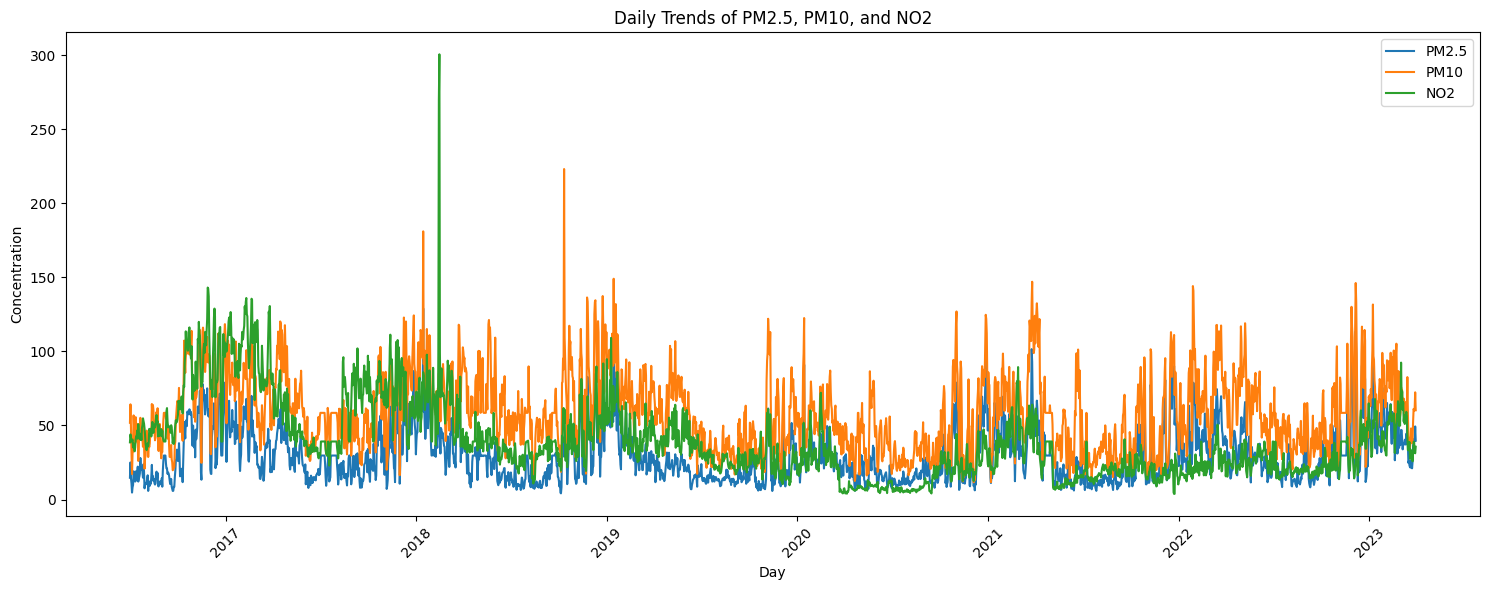

In [ ]:
# Plot time series for key pollutants (example: PM2.5, PM10, NO2)
plt.figure(figsize=(15, 6))
plt.plot(daily_report['Day'], daily_report['PM2.5 (ug/m3)'], label='PM2.5')
plt.plot(daily_report['Day'], daily_report['PM10 (ug/m3)'], label='PM10')
plt.plot(daily_report['Day'], daily_report['NO2 (ug/m3)'], label='NO2')
plt.xlabel("Day")
plt.ylabel("Concentration")
plt.title("Daily Trends of PM2.5, PM10, and NO2")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
#remove  outliers
daily_report = daily_report[daily_report['PM2.5 (ug/m3)'] < daily_report['PM2.5 (ug/m3)'].quantile(0.95)]

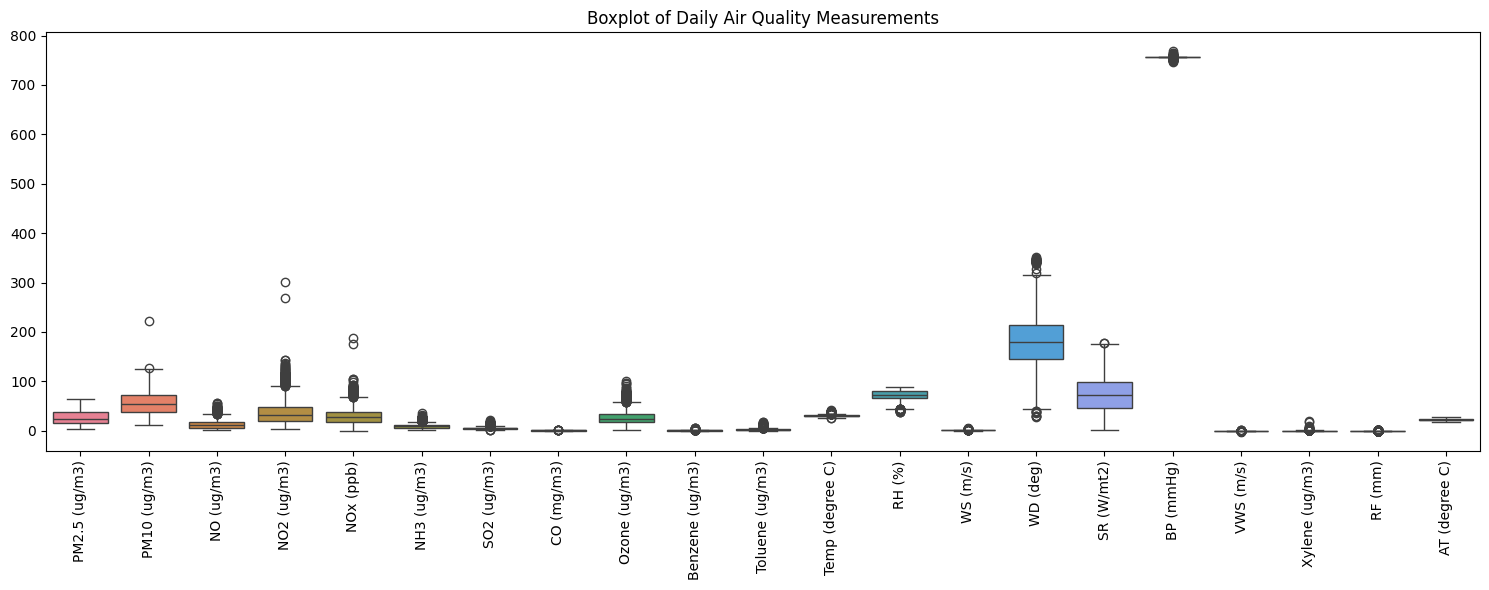

In [ ]:
# 4. Outlier Detection with Boxplots
# --------------------------------------
plt.figure(figsize=(15, 6))
sns.boxplot(data=daily_report.select_dtypes(include=np.number))
plt.xticks(rotation=90)
plt.title("Boxplot of Daily Air Quality Measurements")
plt.tight_layout()
plt.show()

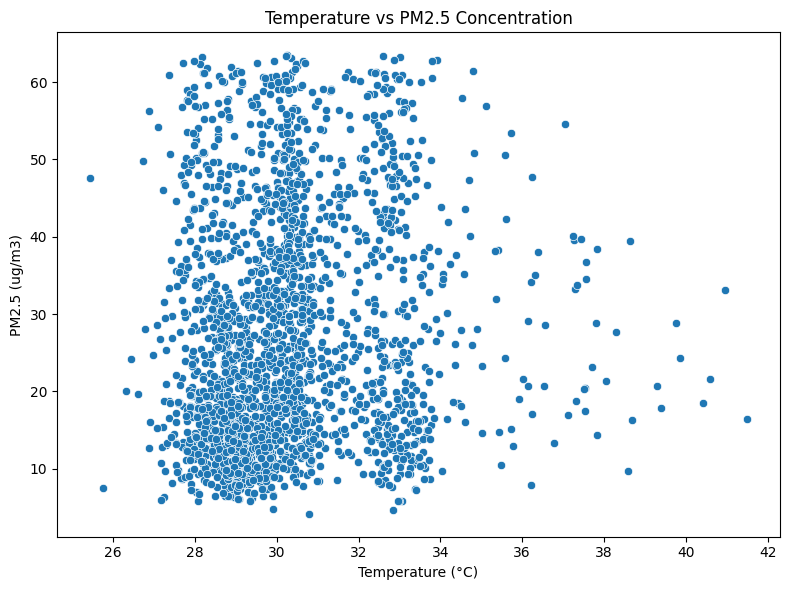

In [ ]:
# Example: Relationship between Temperature and PM2.5
plt.figure(figsize=(8, 6))
sns.scatterplot(x=daily_report['Temp (degree C)'], y=daily_report['PM2.5 (ug/m3)'])
plt.title("Temperature vs PM2.5 Concentration")
plt.xlabel("Temperature (°C)")
plt.ylabel("PM2.5 (ug/m3)")
plt.tight_layout()
plt.show()


In [ ]:
# Calculate moving averages for PM2.5 with larger window sizes
daily_report['PM2.5_MA_60'] = daily_report['PM2.5 (ug/m3)'].rolling(window=60).mean()
daily_report['PM2.5_MA_200'] = daily_report['PM2.5 (ug/m3)'].rolling(window=120).mean()

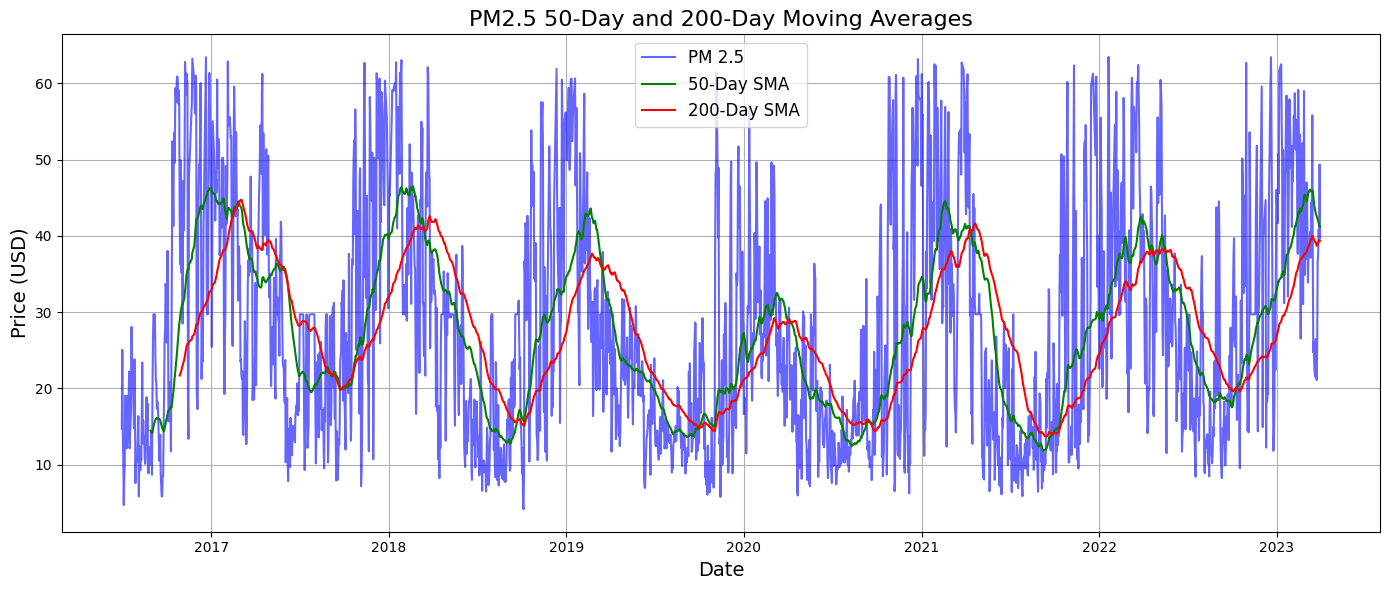

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(daily_report['Day'], daily_report['PM2.5 (ug/m3)'], color='blue', label='PM 2.5', alpha=0.6)
plt.plot(daily_report['Day'], daily_report['PM2.5_MA_60'], color='green', label='50-Day SMA')
plt.plot(daily_report['Day'], daily_report['PM2.5_MA_200'], color='red', label='200-Day SMA')
plt.title('PM2.5 50-Day and 200-Day Moving Averages', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
daily_report.columns

Index(['Day', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)',
       'NOx (ppb)', 'NH3 (ug/m3)', 'SO2 (ug/m3)', 'CO (mg/m3)',
       'Ozone (ug/m3)', 'Benzene (ug/m3)', 'Toluene (ug/m3)',
       'Temp (degree C)', 'RH (%)', 'WS (m/s)', 'WD (deg)', 'SR (W/mt2)',
       'BP (mmHg)', 'VWS (m/s)', 'Xylene (ug/m3)', 'RF (mm)', 'AT (degree C)',
       'PM2.5_MA_60', 'PM2.5_MA_200'],
      dtype='object')

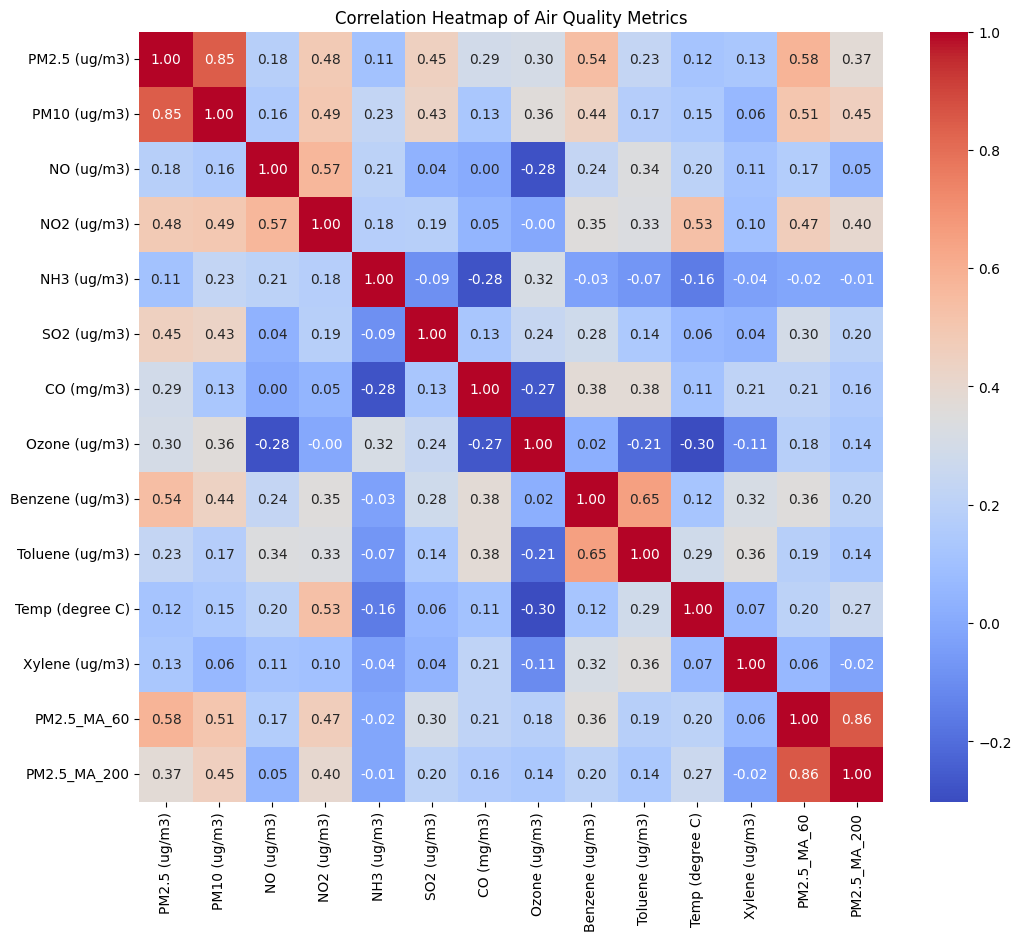

In [ ]:

# Compute correlation matrix and plot a heatmap to identify relationships
df_numeric = daily_report.drop(columns=['Day','RH (%)','NOx (ppb)','WS (m/s)','WD (deg)','SR (W/mt2)','BP (mmHg)','VWS (m/s)','VWS (m/s)','RF (mm)','AT (degree C)',], errors='ignore')
corr_matrix = df_numeric.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Air Quality Metrics")
plt.show()

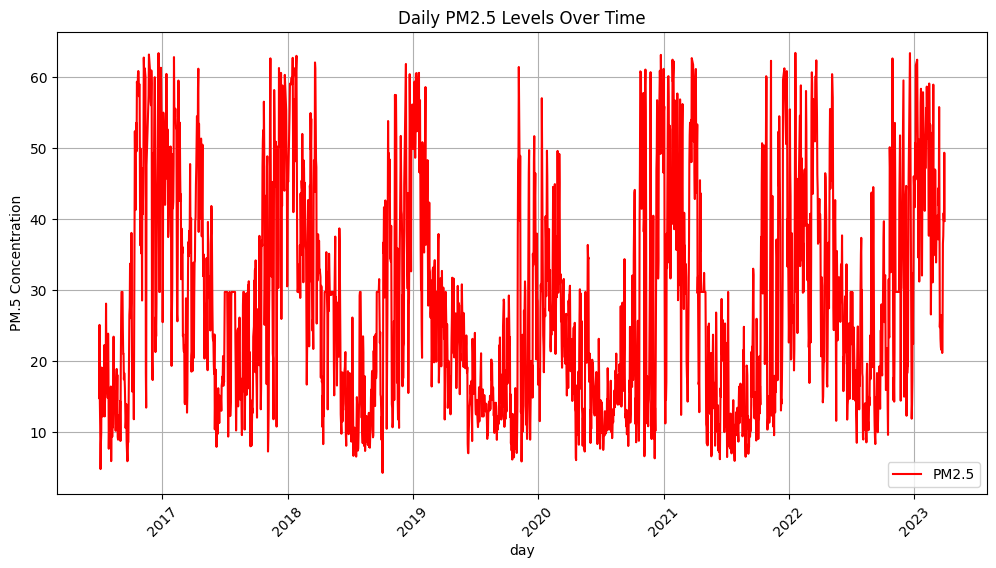

In [ ]:

# Plot PM2.5 levels over time
plt.figure(figsize=(12, 6))
plt.plot(daily_report['Day'], daily_report['PM2.5 (ug/m3)'], label='PM2.5',color= 'red')
plt.xlabel('day')
plt.ylabel('PM.5 Concentration')
plt.title('Daily PM2.5 Levels Over Time')
plt.legend(markerfirst=True)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [ ]:
# Normalize the numerical columns
scaler = StandardScaler()
daily_report[numerical_cols] = scaler.fit_transform(daily_report[numerical_cols])
daily_report

,Day,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),...,WS (m/s),WD (deg),SR (W/mt2),BP (mmHg),VWS (m/s),Xylene (ug/m3),RF (mm),AT (degree C),PM2.5_MA_60,PM2.5_MA_200
0,2016-07-01,-0.856087,-0.164612,0.149952,0.018172,-0.038056,-0.376485,0.226468,-0.682155,-0.824284,...,1.455804,0.718616,0.010077,0.000000e+00,-0.745894,-0.219397,-0.278121,0.589982,NaN,NaN
1,2016-07-02,-0.153161,0.370636,1.007477,0.225437,0.426816,-0.281319,-0.184846,1.184646,-0.634525,...,0.534706,0.152493,0.784714,1.660066e-13,-0.509967,-0.021605,0.139192,0.705374,NaN,NaN
2,2016-07-03,-0.894965,-0.413087,-0.095967,0.128459,-0.067524,-0.256215,-0.043609,0.537786,-0.951753,...,1.156906,0.683280,1.571912,1.660066e-13,0.388864,-0.184035,0.806160,0.708327,NaN,NaN
3,2016-07-04,-1.122571,-1.053842,-0.507228,0.040417,-0.245389,-0.444511,0.080994,0.080354,-0.756458,...,0.613977,1.072475,0.224048,1.660066e-13,0.712483,-0.212872,0.086459,0.199099,NaN,NaN
4,2016-07-05,-1.537329,-1.662468,0.301024,0.071331,0.028978,-0.480789,-0.245872,0.494383,-0.944021,...,1.132186,0.737782,0.150378,1.660066e-13,0.467526,-0.206304,0.198750,0.302859,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2460,2023-03-27,0.698831,0.236320,-0.205268,0.032655,-0.036202,-0.169760,1.152366,1.336724,-1.183088,...,-1.114357,-0.350040,0.528810,1.660066e-13,-1.523886,0.879291,-0.323320,1.261116,41.991021,39.080460
2461,2023-03-28,0.919896,0.180964,-0.596205,0.030399,-0.186418,-0.300009,0.264726,0.979854,-1.010475,...,-1.312868,-0.465370,0.889288,1.660066e-13,-1.821976,1.888615,-0.323320,1.094972,41.731646,39.302172
2462,2023-03-29,0.841867,0.250778,-0.920985,-0.230746,-0.503252,-0.389865,0.910809,0.827140,-1.135646,...,-1.075404,-1.113224,1.379650,1.660066e-13,-1.693632,0.492374,-0.323320,1.138189,41.419992,39.455980
2463,2023-03-30,1.499484,0.721027,-0.903161,-0.267988,-0.524006,-0.353356,2.238106,0.888226,-1.122858,...,-1.219231,-0.860640,1.196185,1.660066e-13,-1.428662,0.453404,-0.323320,1.252089,41.293083,39.420911


**FORECASTING USING ARIMA**

Arima

In [ ]:
plt.rcParams['figure.figsize'] = [10, 7.5]

#Set 'Day' as the index for proper ARIMA forecasting
#daily_report.set_index('Day', inplace=True)
print(daily_report)

             Day  PM2.5 (ug/m3)  PM10 (ug/m3)  NO (ug/m3)  NO2 (ug/m3)  \
0     2016-07-01      -0.856087     -0.164612    0.149952     0.018172   
1     2016-07-02      -0.153161      0.370636    1.007477     0.225437   
2     2016-07-03      -0.894965     -0.413087   -0.095967     0.128459   
3     2016-07-04      -1.122571     -1.053842   -0.507228     0.040417   
4     2016-07-05      -1.537329     -1.662468    0.301024     0.071331   
...          ...            ...           ...         ...          ...   
2460  2023-03-27       0.698831      0.236320   -0.205268     0.032655   
2461  2023-03-28       0.919896      0.180964   -0.596205     0.030399   
2462  2023-03-29       0.841867      0.250778   -0.920985    -0.230746   
2463  2023-03-30       1.499484      0.721027   -0.903161    -0.267988   
2464  2023-03-31       0.844790      0.198066   -0.687153    -0.095815   

      NOx (ppb)  NH3 (ug/m3)  SO2 (ug/m3)  CO (mg/m3)  Ozone (ug/m3)  ...  \
0     -0.038056    -0.376485     0

In [ ]:
# Assuming 'daily_report' DataFrame is already loaded and preprocessed as shown in your code.
# Assuming 'daily_report' has a 'Day' column representing dates.
daily_report = daily_report.reset_index()
# Convert 'Day' column to datetime objects if it's not already
daily_report['Day'] = pd.to_datetime(daily_report['Day'])

In [ ]:
# prompt: dailyreport data  with only pm.5,pm10,NO,NO2,benzene collumns

daily_rpt_arima = daily_report[['Day','PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)', 'Benzene (ug/m3)','PM2.5_MA_60','PM2.5_MA_200']]
# Set 'Day' as the index immediately after preprocessing
daily_rpt_arima.set_index('Day', inplace=True)
daily_rpt_arima


,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),Benzene (ug/m3),PM2.5_MA_60,PM2.5_MA_200
Day,,,,,,,
2016-07-01,-0.856087,-0.164612,0.149952,0.018172,-0.126777,NaN,NaN
2016-07-02,-0.153161,0.370636,1.007477,0.225437,0.189687,NaN,NaN
2016-07-03,-0.894965,-0.413087,-0.095967,0.128459,-0.241832,NaN,NaN
2016-07-04,-1.122571,-1.053842,-0.507228,0.040417,-0.382725,NaN,NaN
2016-07-05,-1.537329,-1.662468,0.301024,0.071331,-0.304430,NaN,NaN
...,...,...,...,...,...,...,...
2023-03-27,0.698831,0.236320,-0.205268,0.032655,1.064885,41.991021,39.080460
2023-03-28,0.919896,0.180964,-0.596205,0.030399,1.062538,41.731646,39.302172
2023-03-29,0.841867,0.250778,-0.920985,-0.230746,-0.573598,41.419992,39.455980


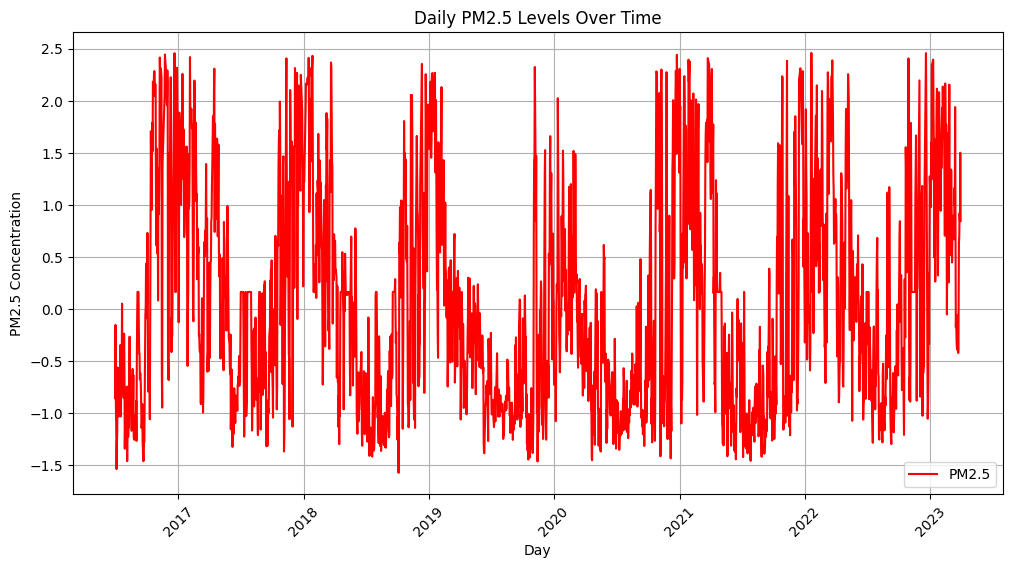

In [ ]:
# Assuming 'daily_report' DataFrame is already loaded and preprocessed.

plt.figure(figsize=(12, 6))
plt.plot(daily_rpt_arima.index, daily_rpt_arima['PM2.5 (ug/m3)'], label='PM2.5', color='red')
plt.xlabel('Day')
plt.ylabel('PM2.5 Concentration')
plt.title('Daily PM2.5 Levels Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


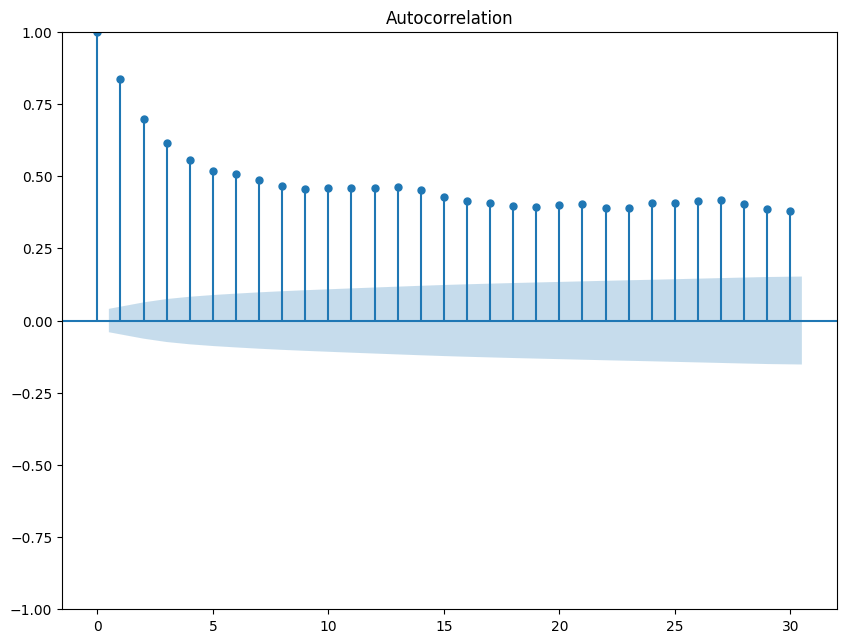

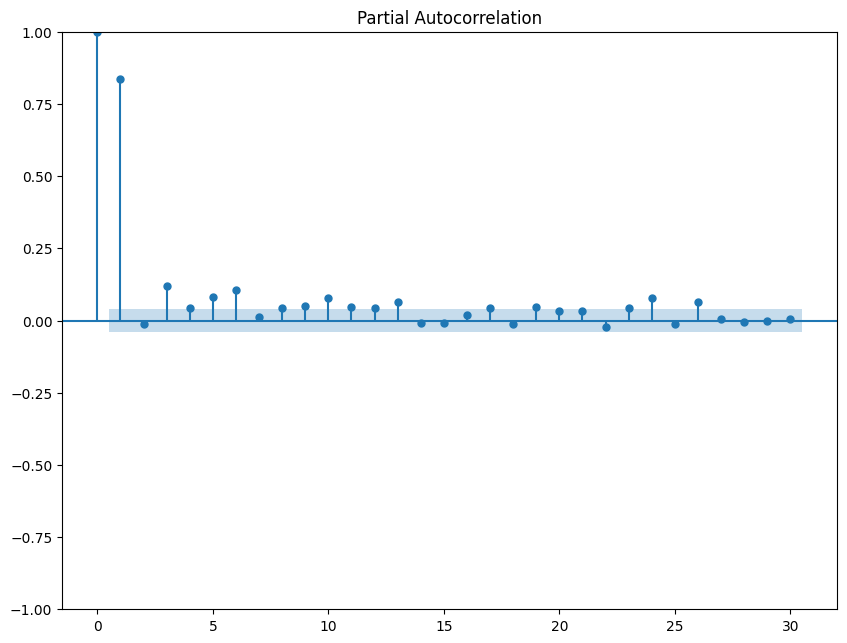

In [ ]:
# Plot ACF and PACF to identify AR and MA terms
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(daily_rpt_arima['PM2.5 (ug/m3)'], lags=30)
plt.show()

plot_pacf(daily_rpt_arima['PM2.5 (ug/m3)'], lags=30)
plt.show()

In [ ]:
#adfuller test to generate the critical values
result = adfuller(daily_rpt_arima['PM2.5 (ug/m3)'], autolag='AIC')

# Extract and print the test results
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'Critical Values:')
for key, value in result[4].items():
  print('\t%s: %.3f' %(key, value))

ADF Statistic: -3.9360357369302315
p-value: 0.0017850818004594663
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

def find_best_aic_model(data, max_p, max_d, max_q):
    """
    Finds ARIMA model with lowest AIC using loop.
    """
    best_aic = np.inf
    best_model = None
    best_order = None
    for p, d, q in product(range(max_p + 1), range(max_d + 1), range(max_q + 1)):
        try:
            model = SARIMAX(data, order=(p, d, q), enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=False)
            aic = model_fit.aic
            if aic < best_aic:
                best_aic = aic
                best_model = model_fit
                best_order = (p, d, q)
        except Exception as e:
            continue  # Ignoring errors during fitting the model
    return best_order, best_aic

# Set the maximum values for p, d,and q
max_p = 8
max_d = 0
max_q = 4


# Running the grid search on the log data
best_order, best_aic = find_best_aic_model(daily_rpt_arima['PM2.5 (ug/m3)'], max_p, max_d, max_q) # Now using the column in the DataFrame
best_order, best_aic

((6, 0, 4), np.float64(3694.495318022673))

In [ ]:
#splitting into training and test data
train_size = int(len(daily_rpt_arima) * 0.8)
train_data = daily_rpt_arima[:train_size]
test_data = daily_rpt_arima[train_size:]

In [ ]:
# Fit ARIMA model on the training dataset
model = ARIMA(train_data['PM2.5 (ug/m3)'],
              order=best_order,exog = train_data[['PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)']])
model_fit = model.fit()

In [ ]:
# Forecast for the test period
forecast = model_fit.forecast(steps=len(test_data),
                              exog = test_data[['PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)']])

In [ ]:
forecast_index = pd.date_range(start=pd.to_datetime(test_data.index[0]) + pd.Timedelta(days=1), periods=len(test_data), freq='D')


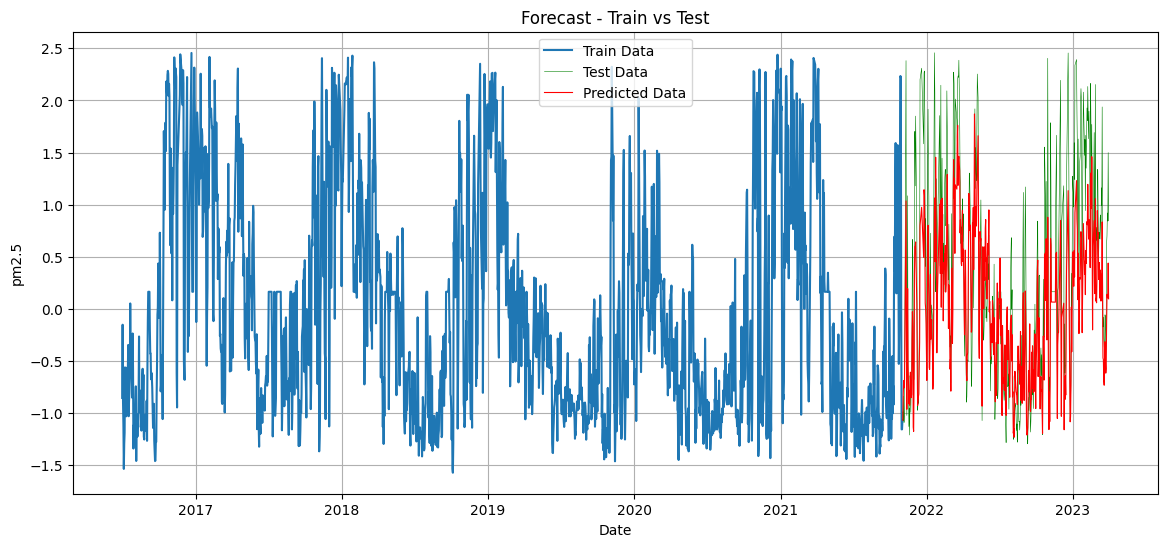

In [ ]:
# Plot the results
plt.figure(figsize=(14, 6))
plt.plot(train_data.index, train_data['PM2.5 (ug/m3)'],
         label="Train Data")
plt.plot(test_data.index, test_data['PM2.5 (ug/m3)'],
         label="Test Data",color = 'green',linewidth = '0.4')
plt.plot(test_data.index, forecast,
         label="Predicted Data", color='red',linewidth = '0.8')
plt.title("Forecast - Train vs Test")
plt.xlabel("Date")
plt.ylabel("pm2.5")
plt.legend()
plt.grid()
plt.show()

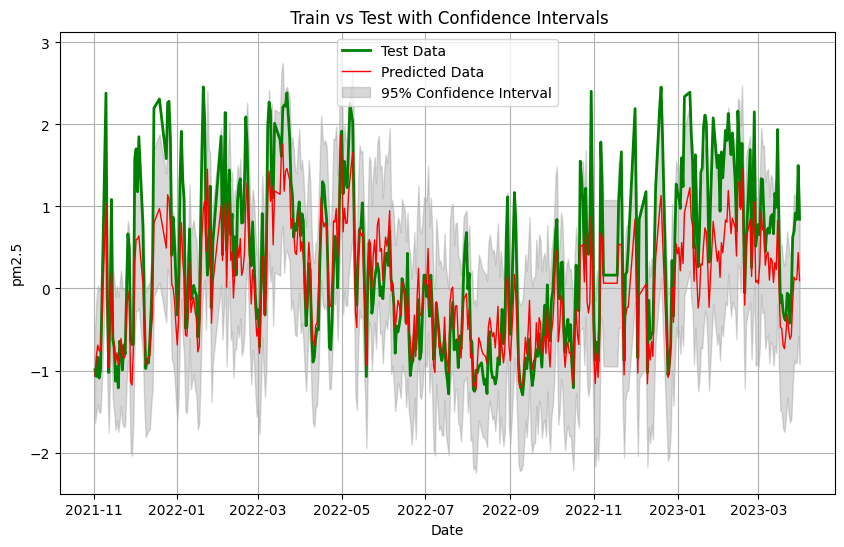

In [ ]:
forecast = model_fit.forecast(
    steps=len(test_data),
    exog=test_data[['PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)']],
)

# Get confidence intervals separately
conf_int = model_fit.get_forecast(steps=len(test_data),
exog=test_data[['PM10 (ug/m3)', 'NO (ug/m3)', 'NO2 (ug/m3)']]).conf_int(alpha=0.05)

# Plot train, test, and forecast data
plt.figure(figsize=(10, 6))
#plt.plot(train_data.index, train_data["Close"], label="Train Data")
plt.plot(test_data.index, test_data["PM2.5 (ug/m3)"], label="Test Data",
         color="green", linewidth=2)
plt.plot(test_data.index, forecast, label="Predicted Data",
         color="red", linewidth=1)

# Fill the confidence interval area
# Access confidence intervals using the correct column names
plt.fill_between(
    test_data.index,
    conf_int['lower PM2.5 (ug/m3)'],  # Lower bound - Updated column name
    conf_int['upper PM2.5 (ug/m3)'],  # Upper bound - Updated column name
    color="gray",
    alpha=0.3,
    label="95% Confidence Interval",
)

# Enhance the plot
plt.title(" Train vs Test with Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("pm2.5")
plt.legend()
plt.grid()
plt.show()

In [ ]:
test_data.index

DatetimeIndex(['2021-11-02', '2021-11-03', '2021-11-04', '2021-11-05',
               '2021-11-06', '2021-11-07', '2021-11-10', '2021-11-11',
               '2021-11-12', '2021-11-13',
               ...
               '2023-03-22', '2023-03-23', '2023-03-24', '2023-03-25',
               '2023-03-26', '2023-03-27', '2023-03-28', '2023-03-29',
               '2023-03-30', '2023-03-31'],
              dtype='datetime64[ns]', name='Day', length=469, freq=None)

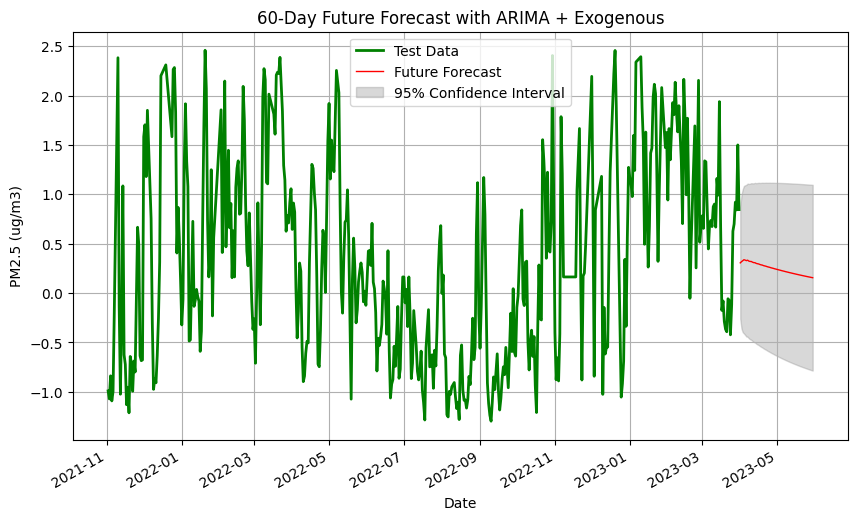

In [ ]:
# Assume test_data.index is a proper DatetimeIndex and test_data is your historical data
last_date = test_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60, freq='D')

# If you don't have real future exogenous data, you might use the mean or last observed values.
pm10_mean = test_data['PM10 (ug/m3)'].mean()
no_mean = test_data['NO (ug/m3)'].mean()
no2_mean = test_data['NO2 (ug/m3)'].mean()

future_exog = pd.DataFrame({
    'PM10 (ug/m3)': [pm10_mean] * 60,
    'NO (ug/m3)':   [no_mean] * 60,
    'NO2 (ug/m3)':  [no2_mean] * 60
}, index=future_dates)

# Forecast using your fitted ARIMA model (model_fit) with the future exogenous data
future_forecast = model_fit.forecast(steps=60, exog=future_exog)

# Reassign the future_dates index to the forecast Series
future_forecast.index = future_dates

# Get confidence intervals for the forecast and reassign the index as well
future_conf_int = model_fit.get_forecast(steps=60, exog=future_exog).conf_int(alpha=0.05)
future_conf_int.index = future_dates

#Plot the Future Forecast with Confidence Intervals
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, test_data["PM2.5 (ug/m3)"], label="Test Data", color="green", linewidth=2)
plt.plot(future_forecast.index, future_forecast, label="Future Forecast", color="red", linewidth=1)
plt.fill_between(
    future_conf_int.index,
    future_conf_int['lower PM2.5 (ug/m3)'],
    future_conf_int['upper PM2.5 (ug/m3)'],
    color="gray",
    alpha=0.3,
    label="95% Confidence Interval"
)
plt.title("60-Day Future Forecast with ARIMA + Exogenous")
plt.xlabel("Date")
plt.ylabel("PM2.5 (ug/m3)")
plt.legend()
plt.grid()
plt.gcf().autofmt_xdate()  # Rotate dates for better readability
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Assuming 'forecast' contains the predicted values and 'test_data' contains the actual values

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test_data['PM2.5 (ug/m3)'], forecast)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_data['PM2.5 (ug/m3)'], forecast)

# Calculate R-squared (R2)
r2 = r2_score(test_data['PM2.5 (ug/m3)'], forecast)

# Print the evaluation metrics
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2: {r2}")

MSE: 0.31447075292322335
RMSE: 0.5607769190357458
MAE: 0.44001373261079435
R2: 0.6668626135827769


# **Random Forest Regression**

In [ ]:
predictors = daily_report[['PM10 (ug/m3)', 'NO (ug/m3)','NO2 (ug/m3)','Benzene (ug/m3)','NH3 (ug/m3)','SO2 (ug/m3)','Toluene (ug/m3)','Xylene (ug/m3)']]
target = daily_report['PM2.5 (ug/m3)']

In [ ]:
# Extract feature matrix (X) and target vector (y)
X = predictors.values
y = target.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],   # More trees can improve accuracy
    'max_depth': [10, 15, 20],         # Try deeper trees
    'min_samples_split': [2, 5, 10],   # Controls splits in trees
    'min_samples_leaf': [1, 2, 4]      # Controls minimum data per leaf
}


In [ ]:
# 7. Use GridSearchCV to perform hyperparameter tuning with 5-fold cross-validation
grid_search = GridSearchCV(RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           scoring='r2',
                           n_jobs=-1,
                           verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 15, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='r2', verbose=2)

In [ ]:
# 8. Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [ ]:
# 9. Retrieve the best model and evaluate its performance on the test set
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
test_score = best_rf.score(X_test, y_test)
print("Test R^2 Score:", test_score)

Test R^2 Score: 0.8593577542354972


In [ ]:
# 10. Get the feature importances from the best model
importances = best_rf.feature_importances_
features = predictors.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

print("\nFeature Importances:")
print(importance_df)


Feature Importances:
           Feature  Importance
0     PM10 (ug/m3)    0.764684
3  Benzene (ug/m3)    0.078096
4      NH3 (ug/m3)    0.041218
7   Xylene (ug/m3)    0.033482
2      NO2 (ug/m3)    0.023432
1       NO (ug/m3)    0.021490
5      SO2 (ug/m3)    0.019226
6  Toluene (ug/m3)    0.018372


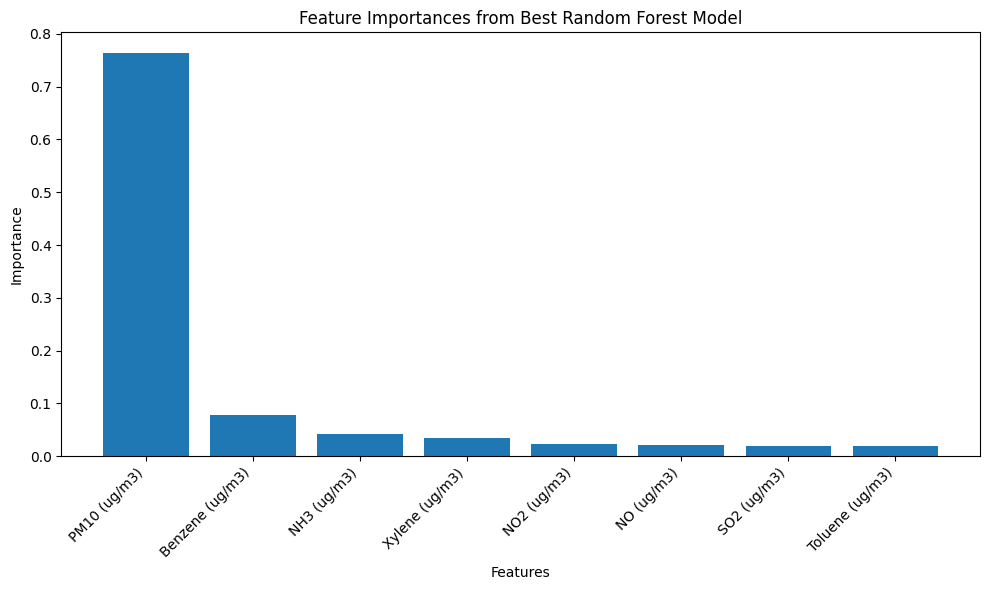

In [ ]:
# 11. (Optional) Plot the feature importances for visualization
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances from Best Random Forest Model")
plt.tight_layout()
plt.show()

In [ ]:
print(y_test.size,y_pred.size)

469 469


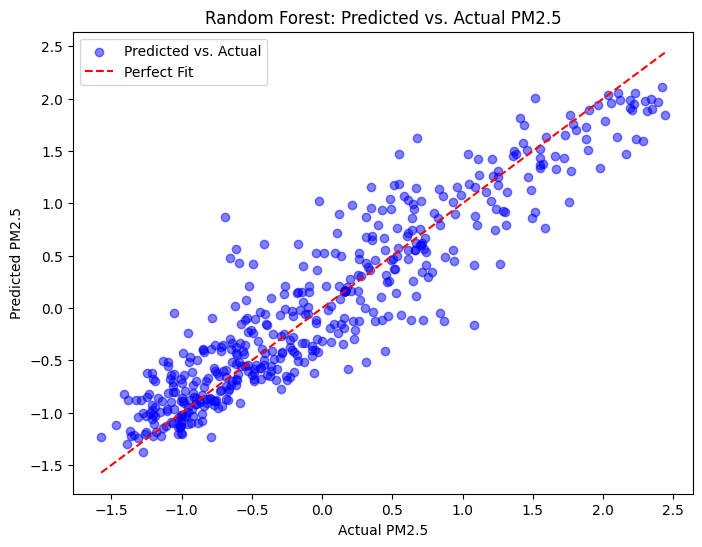

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color="blue", alpha=0.5, label="Predicted vs. Actual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label="Perfect Fit")
plt.xlabel("Actual PM2.5")
plt.ylabel("Predicted PM2.5")
plt.title("Random Forest: Predicted vs. Actual PM2.5")
plt.legend()
plt.show()


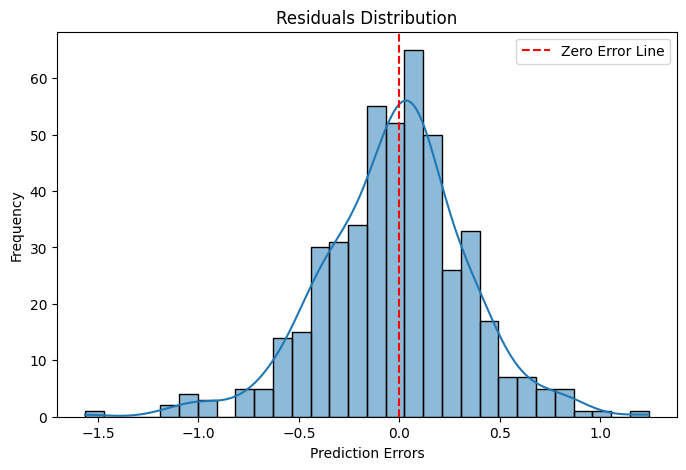

In [ ]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(x=0, color='red', linestyle='--', label="Zero Error Line")
plt.title("Residuals Distribution")
plt.xlabel("Prediction Errors")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [ ]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate R-squared (R² score)
r2 = r2_score(y_test, y_pred)

# Print out the metrics
print("Evaluation Metrics:")
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)

Evaluation Metrics:
Mean Absolute Error (MAE): 0.27069266624206556
Mean Squared Error (MSE): 0.12959710985349762
Root Mean Squared Error (RMSE): 0.3599959858852563
R-squared (R²): 0.8593577542354972


XGBOOST

In [ ]:
from xgboost import XGBRegressor

In [ ]:
predictors = daily_report[['PM10 (ug/m3)', 'NO (ug/m3)','NO2 (ug/m3)','Benzene (ug/m3)','NH3 (ug/m3)','SO2 (ug/m3)','Toluene (ug/m3)','Xylene (ug/m3)']]
target = daily_report['PM2.5 (ug/m3)']

In [ ]:
# Extract feature matrix (X) and target vector (y)
X = predictors.values
y = target.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# 6. Define the hyperparameter grid for XGBoost
param_grid = {
    'n_estimators': [100, 200],        # number of boosting rounds
    'max_depth': [3, 5, 7],            # maximum tree depth for base learners
    'learning_rate': [0.01, 0.1, 0.2],   # step size shrinkage used in update to prevent overfitting
    'subsample': [0.7, 1.0],           # fraction of observations to be randomly samples for each tree
    'colsample_bytree': [0.7, 1.0]
}

In [ ]:
# 7. Initialize the XGBRegressor
#    Note: 'reg:squarederror' is used as the objective for regression problems.
xgb = XGBRegressor(random_state=42, objective='reg:squarederror')

In [ ]:
# 8. Set up GridSearchCV with 5-fold cross-validation using the defined parameter grid
grid_search = GridSearchCV(estimator=xgb,
                           param_grid=param_grid,
                           cv=5,
                           scoring='r2',
                           n_jobs=-1,
                           verbose=2)


In [ ]:

# 9. Fit the grid search to the scaled training data
grid_search.fit(X_train, y_train)

# 10. Print the best hyperparameters found
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Hyperparameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.7}


In [ ]:
# 11. Retrieve the best XGBoost model from grid search and evaluate its performance on the test set
best_xgb = grid_search.best_estimator_
y_pred = best_xgb.predict(X_test)
test_score = best_xgb.score(X_test, y_test)
print("Test R^2 Score:", test_score)

Test R^2 Score: 0.8762710386764433


In [ ]:
# 12. Extract feature importances from the best model
importances = best_xgb.feature_importances_
features = predictors.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

print("\nFeature Importances:")
print(importance_df)


Feature Importances:
           Feature  Importance
0     PM10 (ug/m3)    0.624576
3  Benzene (ug/m3)    0.104593
7   Xylene (ug/m3)    0.064502
4      NH3 (ug/m3)    0.059596
2      NO2 (ug/m3)    0.042513
6  Toluene (ug/m3)    0.039167
1       NO (ug/m3)    0.032609
5      SO2 (ug/m3)    0.032444


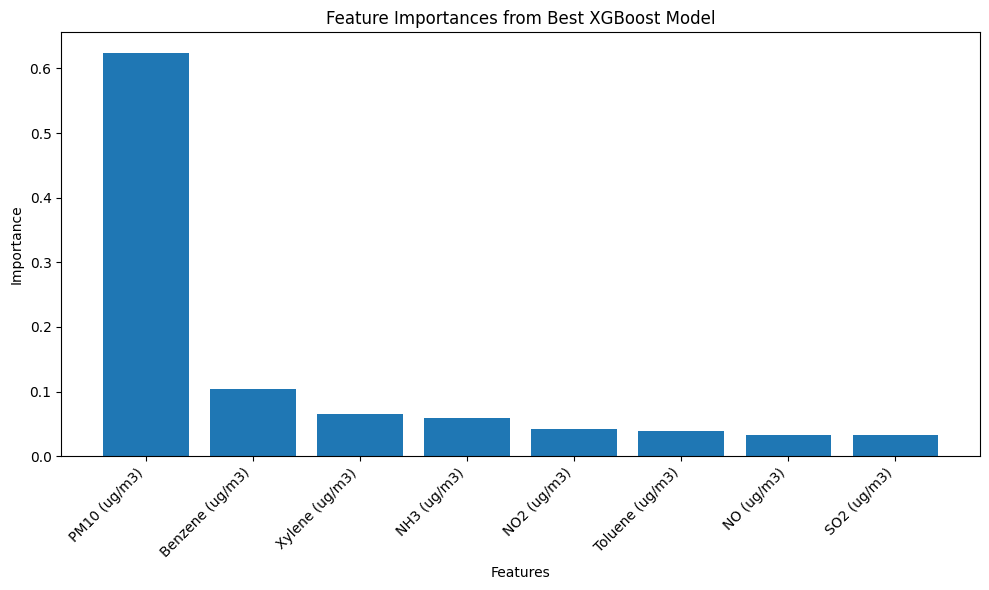

In [ ]:
# 13. (Optional) Plot the feature importances for visualization
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances from Best XGBoost Model")
plt.tight_layout()
plt.show()

In [ ]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate R-squared (R² score)
r2 = r2_score(y_test, y_pred)

# Print out the metrics
print("Evaluation Metrics:")
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R²):", r2)

Evaluation Metrics:
Mean Absolute Error (MAE): 0.27069266624206556
Mean Squared Error (MSE): 0.12959710985349762
Root Mean Squared Error (RMSE): 0.3599959858852563
R-squared (R²): 0.8593577542354972


# **LSTM** **MODEL**

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [ ]:
# Normalize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback])
    return np.array(X), np.array(y)

In [ ]:
# Define the lookback period (number of timesteps used for prediction)
lookback = 10
X, y = create_sequences(data_scaled, lookback)

train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

dates_test = daily_report['Day'][train_size + lookback:]


In [ ]:
# 4. Build the LSTM model with hyperparameter tuning
def build_model(hp):
    model = Sequential()
    # Tune the number of LSTM units (e.g., 32 to 128 in steps of 32)
    units = hp.Int('units', min_value=32, max_value=128, step=32)
    model.add(LSTM(units, input_shape=(lookback, 1)))

    # Tune dropout rate between 0.0 and 0.5
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
    model.add(Dropout(dropout_rate))

    # Optionally add a dense hidden layer with tunable size
    dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=16)
    model.add(Dense(dense_units, activation='relu'))

    # Output layer
    model.add(Dense(1))

    # Tune learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Set up Keras Tuner (using RandomSearch here)
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=1,           # Number of hyperparameter combinations to try
    executions_per_trial=2,  # Run each trial multiple times for robustness
    directory='lstm_tuner',
    project_name='pm5_forecast'
)

# Print a summary of the search space
tuner.search_space_summary()
#set the hypertuner
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, verbose=1)

# Display the best hyperparameters found
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:")
print(best_hp.values)


Trial 1 Complete [00h 02m 08s]
val_loss: 0.33385930955410004

Best val_loss So Far: 0.33385930955410004
Total elapsed time: 00h 02m 08s
Best hyperparameters:
{'units': 128, 'dropout_rate': 0.0, 'dense_units': 64, 'learning_rate': 0.002378558206931083}


In [ ]:
#evaluate the best model
best_model = tuner.get_best_models(num_models=1)[0]
test_loss, test_mae = best_model.evaluate(X_test, y_test)
print("Test Loss (MSE):", test_loss)
print("Test MAE:", test_mae)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4522 - mae: 0.4890
Test Loss (MSE): 0.3827967047691345
Test MAE: 0.4533350169658661


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


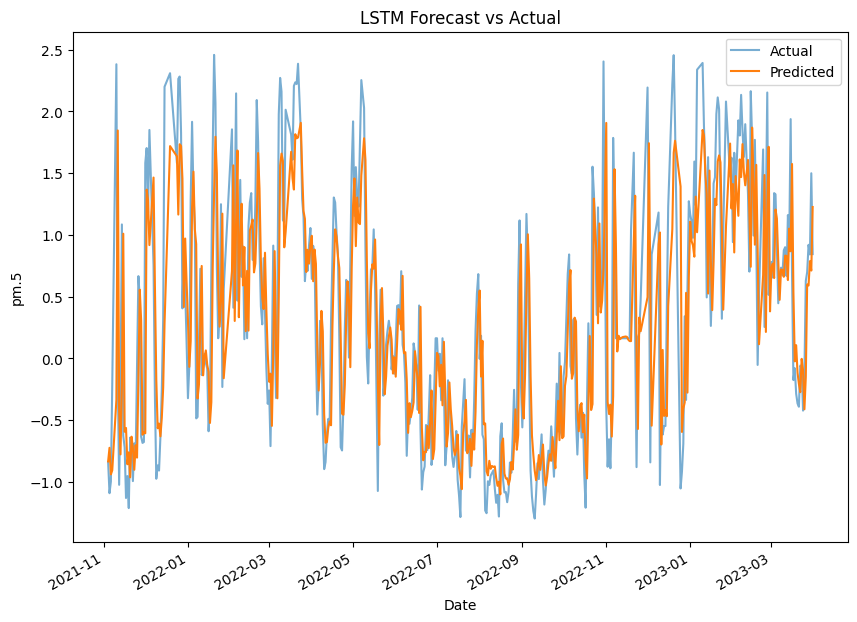

In [ ]:
#Make predictions and plot results
y_pred = best_model.predict(X_test)

# Inverse transform predictions and actual values to original scale
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

# Convert numpy datetime-like array to a Pandas Series (optional) for plotting convenience
dates_test_series = pd.to_datetime(dates_test)

plt.plot(dates_test_series, y_test_inv, label='Actual',alpha=0.6)
plt.plot(dates_test_series, y_pred_inv, label='Predicted')

plt.xlabel('Date')
plt.ylabel('pm.5')
plt.title('LSTM Forecast vs Actual')

plt.legend()
plt.gcf().autofmt_xdate()  # Rotate dates for better readability
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# Function to Iteratively Forecast Future Days
# -------------------------------
def forecast_future(model, last_sequence, forecast_horizon):
    """
    Iteratively forecast future values using the trained LSTM model.

    Parameters:
      model           : Trained LSTM model.
      last_sequence   : Last sequence from your data (shape: (lookback, 1)).
      forecast_horizon: Number of days to forecast.

    Returns:
      forecast        : Array of forecasted scaled values.
    """
    forecast = []
    current_sequence = last_sequence.copy()  # shape: (lookback, 1)

    for _ in range(forecast_horizon):
        # Reshape to (1, lookback, 1) as expected by the model
        pred = model.predict(current_sequence[np.newaxis, :, :])
        forecast.append(pred[0, 0])
        # Update sequence: drop the first value and append the prediction
        current_sequence = np.vstack((current_sequence[1:], pred))

    return np.array(forecast)

# Set Forecast Horizon and Get the Last Sequence from Test Data
forecast_horizon = 60  # 60 days forecast
last_sequence = X_test[-1]  # Use the last sequence from your test set; shape: (lookback, 1)

# Generate the Future Forecast scaled values
future_forecast_scaled = forecast_future(best_model, last_sequence, forecast_horizon)

# Inverse transform to get predictions in the original scale
future_forecast = scaler.inverse_transform(future_forecast_scaled.reshape(-1, 1)).flatten()

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
# For 95% confidence interval (assuming normally distributed errors, z=1.96)
lower_bound = future_forecast - 1.96 * rmse
upper_bound = future_forecast + 1.96 * rmse

# Use the last date from your dates_test_series as the starting point for the future forecast.
last_date = dates_test_series.iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

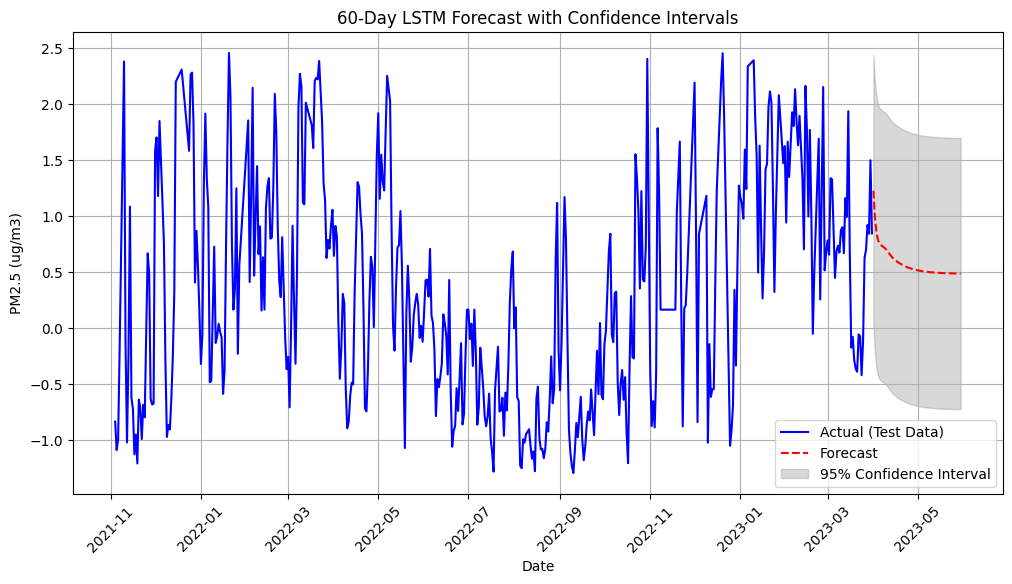

In [ ]:
# --- Plot the 60-Day Forecast with Confidence Intervals ---
plt.figure(figsize=(12, 6))
plt.plot(dates_test_series, y_test_inv, label="Actual (Test Data)", color='blue')
plt.plot(future_dates, future_forecast, label='Forecast', color='red', linestyle='--')
plt.fill_between(future_dates, lower_bound, upper_bound, color='gray', alpha=0.3, label='95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('PM2.5 (ug/m3)')
plt.title('60-Day LSTM Forecast with Confidence Intervals')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test_inv, y_pred_inv)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test_inv, y_pred_inv)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate R-squared (R²) Score
r2 = r2_score(y_test_inv, y_pred_inv)

# Print out the evaluation metrics
print("Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")

Evaluation Metrics:
Mean Absolute Error (MAE): 0.45333504802889063
Mean Squared Error (MSE): 0.3827967013615734
Root Mean Squared Error (RMSE): 0.6187056661786551
R-squared (R²): 0.592934942062932
